# 1. Install Dependencies and Setup

In [1]:
!pip install tensorflow opencv-python matplotlib

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/e4/14/d795bb156f8cc10eb1dcfe1332b7dbb8405b634688980aa9be8f885cc888/tensorflow-2.16.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/76/9e/4d47a69d3338a00c51535028d25a7d1a17c4762e4a46ae6a577f495de252/opencv_python-4.10.0.82-cp37-abi3-win_amd64.whl.metadata
  Using cached opencv_python-4.10.0.82-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/c6/c8/6936e8c7b279a5abac82f399d8d72ac25da530cf5f78a0e40063e492558c/matplotlib-3.9.0-cp311-cp311-win_amd64.whl.metadata
  Using cached matplotlib-3.9.0-cp311-cp311-win_amd64.whl.metadata (11 kB)
  Obtaining dependency information for tensorflow-intel==2.16.1 from https://files.pythonhosted.org/packages/e0/36/6278e4e7e69a90c00e0f82944d8f2713dd85a69d1add455d9e50446837ab/tensorflow_intel-2


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip list

Package                      Version
---------------------------- --------------
absl-py                      2.1.0
anyio                        4.4.0
argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
arrow                        1.3.0
asttokens                    2.4.1
astunparse                   1.6.3
async-lru                    2.0.4
attrs                        23.2.0
Babel                        2.15.0
beautifulsoup4               4.12.3
bleach                       6.1.0
certifi                      2024.6.2
cffi                         1.16.0
charset-normalizer           3.3.2
colorama                     0.4.6
comm                         0.2.2
contourpy                    1.2.1
cycler                       0.12.1
debugpy                      1.8.1
decorator                    5.1.1
defusedxml                   0.7.1
executing                    2.0.1
fastjsonschema               2.19.1
flatbuffers                  24.3.25
fonttools                    4.


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import tensorflow as tf

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

# 2. Load Data

In [6]:
import numpy as np
from matplotlib import pyplot as plt

In [7]:
batch_size = 32
img_height = 256
img_width = 256

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  'data/train',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1168 files belonging to 6 classes.
Using 935 files for training.


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  "data/test",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 250 files belonging to 6 classes.
Using 50 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['Cirrus', 'Cumulonimbus', 'Cumulus', 'Nimbostratus', 'Stratocumulus', 'Stratus']


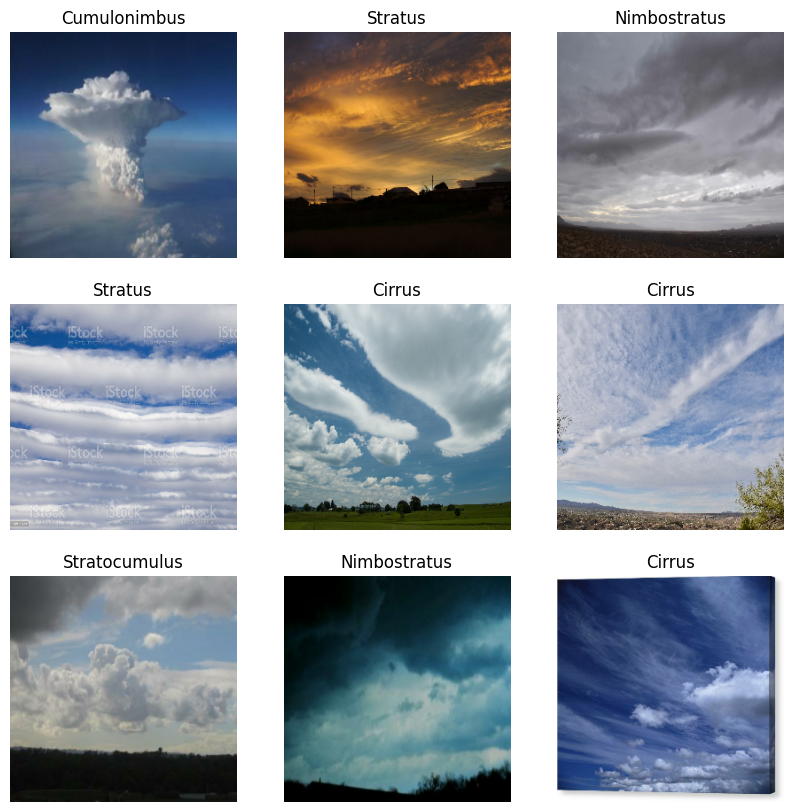

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 3. Scale Data

In [13]:
from tensorflow.keras import layers

normalization_layer = layers.Rescaling(1./255)

In [14]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


# 4. Augment Data

In [15]:
from tensorflow.keras import layers
from tensorflow import keras

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

C:\Users\cedri\Documents\GitHub\Projet-ML-\.venv\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


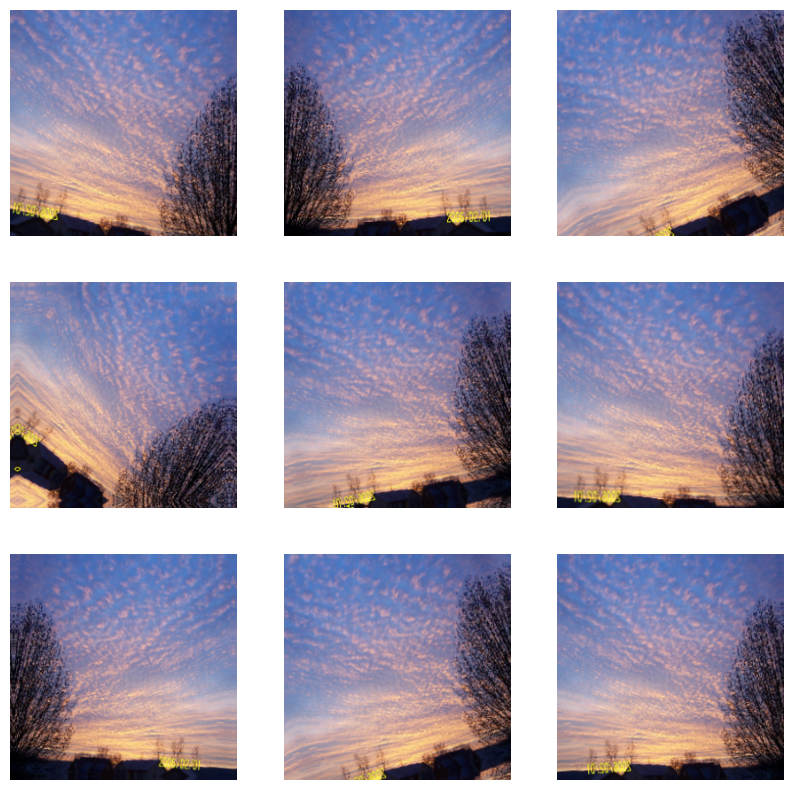

In [16]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# 6. Build Deep Learning Model

In [17]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [18]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [19]:
model = Sequential()
num_classes = len(class_names)

In [20]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # Assuming multi-class classification
])

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# 7. Train

In [22]:
logdir='logs'

In [23]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [24]:
epochs = 20
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[tensorboard_callback])

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 0.3646 - loss: 1.6506 - val_accuracy: 0.5200 - val_loss: 1.4037
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 0.4416 - loss: 1.4475 - val_accuracy: 0.4000 - val_loss: 1.3319
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - accuracy: 0.4864 - loss: 1.3369 - val_accuracy: 0.5400 - val_loss: 1.2853
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.5521 - loss: 1.2203 - val_accuracy: 0.5600 - val_loss: 1.1609
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 0.6122 - loss: 1.0183 - val_accuracy: 0.4600 - val_loss: 1.4118
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 0.6735 - loss: 0.8756 - val_accuracy: 0.5000 - val_loss: 1.2264
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.7509 - loss: 0.6941 - val_accuracy: 0.5200 - val_loss: 1.2717
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.8143 - loss: 0.5768 - val_accuracy: 0.

# 8. Plot Performance

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

Text(0.5, 1.0, 'Training and Validation Accuracy')

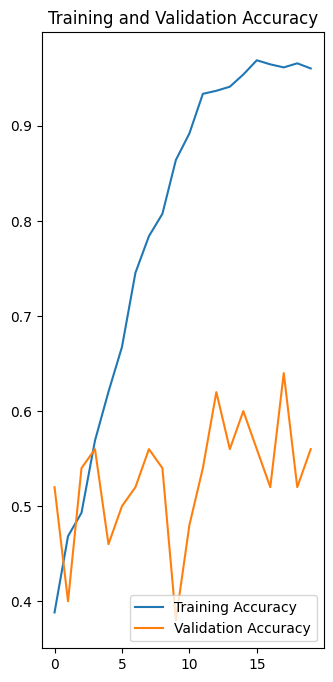

In [26]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

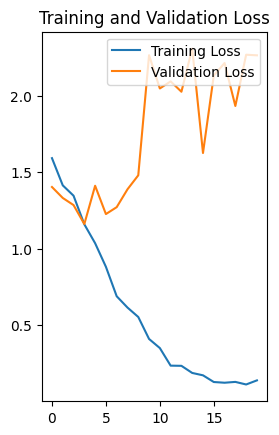

In [27]:
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 9. Evaluate

In [28]:
from keras.src.metrics import Precision, Recall, BinaryAccuracy

In [29]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [30]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


# 10. Test

In [31]:
test_image = 'Cirrocumulus_undulatus_in_various_directions.jpeg'

In [32]:
img = tf.keras.utils.load_img(
    test_image, target_size=(img_height, img_width)
)

In [33]:
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

In [34]:
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


In [35]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Cirrus with a 34.73 percent confidence.


# 11. Save the Model

In [38]:
# Save the model as a SavedModel
model.save("models/cloud_classification.keras")